In [25]:
import scipy.stats as stats
import os
import pandas as pd
import pickle as pk
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib as mpl
from decimal import Decimal

In [28]:
mpl.rcParams["pdf.fonttype"] = 42
mpl.rc('text', usetex = False)

In [4]:
df_SCC = pk.load(open("df_SCC.pk", "rb"))
df_BCC = pk.load(open("df_BCC.pk", "rb"))

df_SCC.reset_index(level=0, inplace=True)
df_BCC.reset_index(level=0, inplace=True)

DE_path = "../DE/one.vs.rest/"
df={}
for i in range(1,8):
    df_tmp = pd.read_csv(os.path.join(DE_path, 'stage{}.csv'.format(i)))
    df_tmp = df_tmp.rename(columns={'Unnamed: 0': "Gene Name"})
    df[i] = df_tmp.sort_values(by='logFC').reset_index()
    print("{} | shape:{} |".format(i, df[i].shape))

1 | shape:(4882, 8) |
2 | shape:(4819, 8) |
3 | shape:(4419, 8) |
4 | shape:(3433, 8) |
5 | shape:(3924, 8) |
6 | shape:(4518, 8) |
7 | shape:(4057, 8) |


In [6]:
def gaussian_kernel(mu, sigma, x):
    num = -((mu-x)*(mu-x))
    den = 2*sigma*sigma
    return math.exp(num/den)

def smooth(x, lim, cutoff, sigma):
    window = cutoff*sigma
    out = []
    for i in range(lim):
        if i == 0:
            w = 0
            for k in range(0, min(math.ceil(window), lim)):
                w += gaussian_kernel(i, sigma, k)
        else:
            if i - math.ceil(window) <= 0:
                w += gaussian_kernel(i, sigma, 0)
            if i + math.floor(window) >= lim:
                w -= gaussian_kernel(i, sigma, lim)
        val = 0
        for elem in x:
            if abs(elem-i) <= math.floor(window):
                val += gaussian_kernel(i, sigma, elem)
        out.append(val/w)
    return np.array(out)

def get_plot_data(x, lim, sigma, cutoff):
    x_out = np.array(range(lim))
    y_out = smooth(x, lim, cutoff, sigma)
    return x_out, y_out

def plot_smooth(x, label, lim, sigma, cutoff, xlim=None, ylim=None):
    x_out, y_out = get_plot_data(x, lim, sigma, cutoff)
    plt.plot(x_out, y_out, label=label)
    if ylim is not None:
        plt.ylim(ylim)
    if xlim is not None:
        plt.xlim(xlim)

In [151]:
to_scientific(2, 2)

('2.0', '{0}')

In [150]:
def to_scientific(d, sig_fig):
    tuple_rep = Decimal(d).as_tuple()
    digits = tuple_rep.digits
    kept_digits = ''
    n_digits = len(digits)
    for i in range(min(sig_fig, n_digits)):
        kept_digits += str(digits[i])
        if i == 0:
            kept_digits += '.'
        if n_digits == 1:
            kept_digits += '0'
    n_digits = len(digits)
    tuple_exp = tuple_rep.exponent
    exp = n_digits + tuple_exp - 1
    exp_str = '{' + str(exp) + '}'
    return kept_digits, exp_str

In [146]:
def get_common_genes_custom(df_cancer, df, title, thresh, y_lim, nSamples=100, savepath=None, sigma=1000, cutoff=3):
    plt.figure(figsize=(20,30))
    for i in range(1, 8):
        df_stage = df[i]
        df_cancer_filt = df_cancer[df_cancer['Gene Name'].isin(df_stage['Gene Name'])]
        df_cancer_filt = df_cancer_filt.set_index('Gene Name')
        df_cancer_indic = df_cancer_filt[df_cancer_filt["Q-Value"] < thresh].drop("Q-Value", axis=1)["Indicator"]
        df_stage_logfc = df_stage.set_index('Gene Name')[['logFC']]
        genes_sorted = df_stage_logfc.index.values.tolist()
        xvals_up = np.nonzero(np.isin(genes_sorted, df_cancer_indic.index[df_cancer_indic.values == 1]))[0]
        xvals_down =  np.nonzero(np.isin(genes_sorted, df_cancer_indic.index[df_cancer_indic.values == -1]))[0]
        y_full = np.array(range(df_stage.shape[0]))
        xvals_up_flipped = df_stage.shape[0] - 1 - xvals_up
        x_full = np.concatenate((xvals_down, xvals_up_flipped))
        dirRankSum, p = stats.mannwhitneyu(x_full, y_full, alternative='less')
        plt.subplot(740+i)
        x_lim = None
        if df_cancer is df_BCC:
            y_lim = ylim_BCC
        if df_cancer is df_SCC:
            y_lim = ylim_SCC
        b = plot_smooth(xvals_down, "Downregulated", len(genes_sorted), 
                        sigma=sigma, cutoff=cutoff, xlim=x_lim, ylim=y_lim)
        a = plot_smooth(xvals_up, "Upregulated", len(genes_sorted), 
                        sigma=sigma, cutoff=cutoff, xlim=x_lim, ylim=y_lim)
        p_less = False
        if p == 0:
            p = 1/nSamples
            comparison = '<'
        else:
            comparison = '='
        digits, exp = to_scientific(p, 2)
        plt.title('Stage {}: '.format(i) + r'$p{}{} \times 10^{}$'.format(comparison, digits, exp),
                  fontsize=22)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        if i in [1, 5]:
            plt.ylabel("Probability", fontsize=30)
        if i in [5, 6, 7]:
            plt.xlabel("Gene Rank", fontsize=30)
    lgd = plt.legend(bbox_to_anchor=(1.05, 0.7), fontsize=26)
    sup = plt.suptitle(title, y = 0.91, fontsize=32)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.25, hspace=0.3)
    if savepath is not None:
        plt.savefig(savepath, format='pdf')
    plt.show()

In [121]:
v = '10^{}'.format('{-3}')

In [124]:
v = '{-3}'

Text(0.5,1,'hi $10^{-3}$')

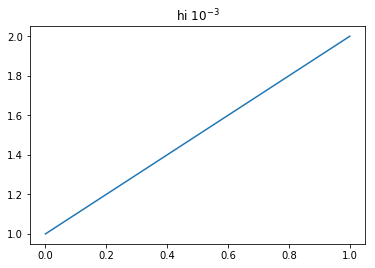

In [127]:
plt.plot([1,2])
x = 'hi ' + r'$10^{}$'.format(v)
plt.title(x)

In [101]:
a

'abc'

In [100]:
a = r'abc'

In [8]:
ylim_BCC = (0, 0.028)
ylim_SCC = (0, 0.6)

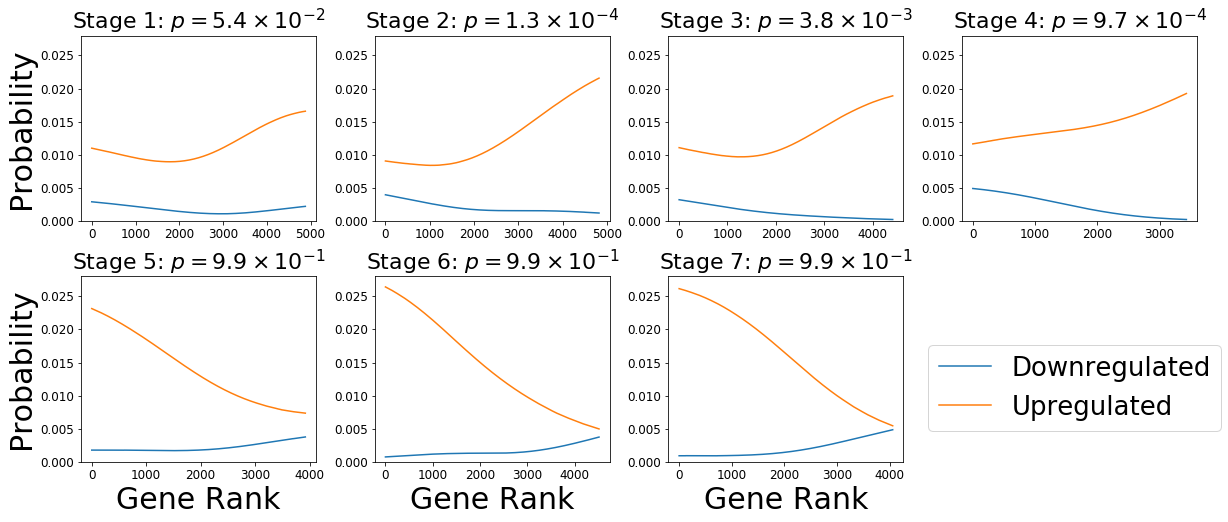

In [147]:
get_common_genes_custom(df_BCC, df, '', thresh=0.05, y_lim=ylim_BCC, savepath='BCC_final.pdf')

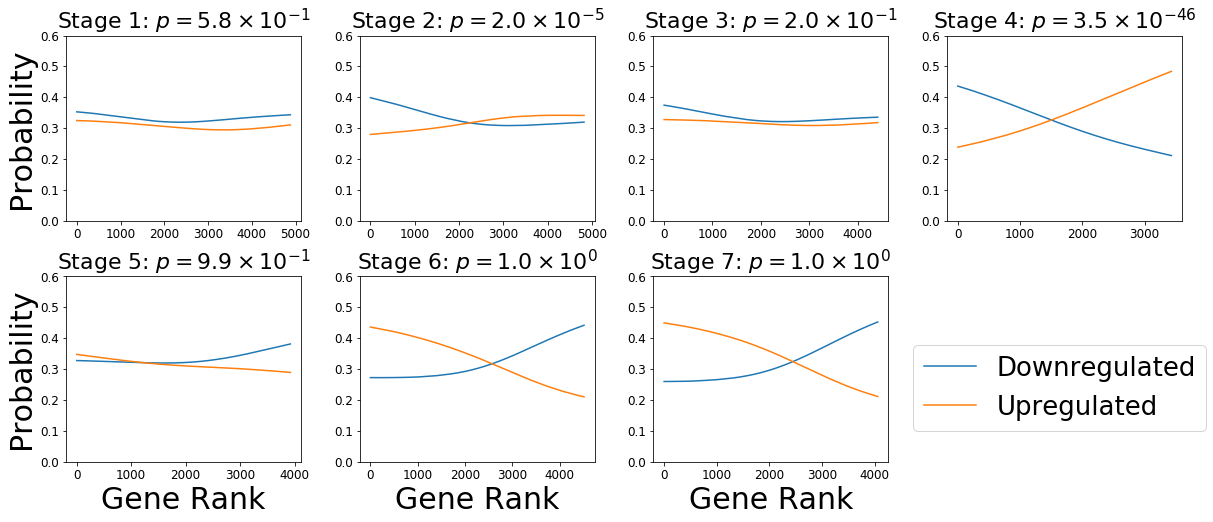

In [152]:
get_common_genes_custom(df_SCC, df, '', thresh=0.05, y_lim=ylim_SCC, savepath='SCC_final.pdf')